In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter, freqz

In [31]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Параметры
Fs = 512
T = 1000 
N_EMG = 8
N_joints = 1

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Генерация сырых данных ЭМГ
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
b_vel, a_vel = butter_filter(order=1, cutoff=2, btype='low', fs=Fs)
b_hp, a_hp = butter_filter(order=3, cutoff=0.1, btype='high', fs=Fs)

s = lfilter(b_myo, a_myo, np.random.randn(N_EMG, len(t)))

input_signal = torch.tensor(s.copy())
# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)
target_signal = torch.abs(torch.matmul(torch.tensor(A.copy()), input_signal))
target_signal = torch.tensor(lfilter(b_vel, a_vel, target_signal, axis=1))
target_signal = torch.tensor(lfilter(b_hp, a_hp, target_signal, axis=1))

# Разделение данных на обучающую и валидационную выборки
train_ratio = 0.8
train_size = int(input_signal.shape[1] * train_ratio)
val_size = input_signal.shape[1] - train_size

train_input = input_signal[:, :train_size]
train_target = target_signal[:, :train_size]
val_input = input_signal[:, train_size:]
val_target = target_signal[:, train_size:]

train_input.shape, train_target.shape, val_input.shape, val_target.shape   

# Разбиение на окна
window_size = 2048

def create_windows(signal, target, window_size):
    x, y = [], []
    for i in range(0, signal.shape[1] - window_size + 1, window_size):
        x.append(signal[:, i:i+window_size])
        y.append(target[:, i:i+window_size])
    return torch.stack(x), torch.stack(y)

train_x, train_y = create_windows(train_input, train_target, window_size)
val_x, val_y = create_windows(val_input, val_target, window_size)

train_x.shape, train_y.shape, val_x.shape, val_y.shape  

class EMGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].to(torch.float32), self.y[idx].to(torch.float32)

train_dataset = EMGDataset(train_x, train_y)
val_dataset = EMGDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, 
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1,
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        return out

class SimpleNN(nn.Module):
    def __init__(self, kernel_size=3, num_blocks=25, block_expansion=1):
        super(SimpleNN, self).__init__()

        self.weight = nn.Parameter(torch.randn(N_joints, N_EMG), requires_grad=True)

        self.conv1 = nn.Conv1d(1, block_expansion, kernel_size, padding=(kernel_size - 1) // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(block_expansion)

        # Создаем и объединяем остаточные блоки
        self.res_layers = self._make_layer(ResidualBlock, block_expansion, num_blocks, kernel_size)

        self.conv = nn.Conv1d(block_expansion, 1, kernel_size, padding=1, bias=False)
        self.bn = nn.BatchNorm1d(1)

    def _make_layer(self, block, out_channels, num_blocks, kernel_size):
        layers = []
        in_channels = out_channels
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels, kernel_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x.shape: [batch_size(64), N_EMG(8), window_size(256)]
        x = torch.abs(torch.matmul(self.weight, x))

        x = self.conv1(x)
        x = self.bn1(x)

        # x = self.res_layers(x)

        # x = self.conv(x)
        # x = self.bn(x)

        return x
    
# Гиперпараметры
epochs = 2_000
learning_rate = 0.001

model = SimpleNN(kernel_size=101).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100, verbose=True, min_lr=1e-6)

def train():
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Обновление шедулера
        scheduler.step()
        # scheduler.step(val_loss)

        # Логирование
        if epoch % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            # current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

train()


Epoch 0/2000, Train Loss: 1.0194, Val Loss: 0.7285, LR: 0.001000
Epoch 100/2000, Train Loss: 0.3727, Val Loss: 0.3713, LR: 0.000900
Epoch 200/2000, Train Loss: 0.1196, Val Loss: 0.1221, LR: 0.000810
Epoch 300/2000, Train Loss: 0.0390, Val Loss: 0.0399, LR: 0.000729
Epoch 400/2000, Train Loss: 0.0163, Val Loss: 0.0161, LR: 0.000656
Epoch 500/2000, Train Loss: 0.0105, Val Loss: 0.0101, LR: 0.000590
Epoch 600/2000, Train Loss: 0.0094, Val Loss: 0.0085, LR: 0.000531
Epoch 700/2000, Train Loss: 0.0083, Val Loss: 0.0078, LR: 0.000478
Epoch 800/2000, Train Loss: 0.0080, Val Loss: 0.0074, LR: 0.000430
Epoch 900/2000, Train Loss: 0.0081, Val Loss: 0.0071, LR: 0.000387
Epoch 1000/2000, Train Loss: 0.0078, Val Loss: 0.0070, LR: 0.000349
Epoch 1100/2000, Train Loss: 0.0076, Val Loss: 0.0069, LR: 0.000314
Epoch 1200/2000, Train Loss: 0.0076, Val Loss: 0.0068, LR: 0.000282
Epoch 1300/2000, Train Loss: 0.0073, Val Loss: 0.0068, LR: 0.000254
Epoch 1400/2000, Train Loss: 0.0076, Val Loss: 0.0068, LR: 0

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Параметры
Fs = 512
T = 1000 
N_EMG = 8
N_joints = 1

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Генерация сырых данных ЭМГ
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
b_vel, a_vel = butter_filter(order=1, cutoff=2, btype='low', fs=Fs)
b_hp, a_hp = butter_filter(order=3, cutoff=0.1, btype='high', fs=Fs)

s = lfilter(b_myo, a_myo, np.random.randn(N_EMG, len(t)))

input_signal = torch.tensor(s.copy())
# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)
target_signal = torch.abs(torch.matmul(torch.tensor(A.copy()), input_signal))
target_signal = torch.tensor(lfilter(b_vel, a_vel, target_signal, axis=1))
target_signal = torch.tensor(lfilter(b_hp, a_hp, target_signal, axis=1))

# Разделение данных на обучающую и валидационную выборки
train_ratio = 0.8
train_size = int(input_signal.shape[1] * train_ratio)
val_size = input_signal.shape[1] - train_size

train_input = input_signal[:, :train_size]
train_target = target_signal[:, :train_size]
val_input = input_signal[:, train_size:]
val_target = target_signal[:, train_size:]

train_input.shape, train_target.shape, val_input.shape, val_target.shape   

# Разбиение на окна
window_size = 512
downsample_size = 64
downsample_scale = window_size // downsample_size

def create_windows(signal, target, window_size):
    x, y = [], []
    for i in range(0, signal.shape[1] - window_size + 1, window_size):
        x.append(signal[:, i:i+window_size])
        y.append(target[:, i:i+window_size][:, ::downsample_scale])
    return torch.stack(x), torch.stack(y)

train_x, train_y = create_windows(train_input, train_target, window_size)
val_x, val_y = create_windows(val_input, val_target, window_size)

train_x.shape, train_y.shape, val_x.shape, val_y.shape  

class EMGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].to(torch.float32), self.y[idx].to(torch.float32)

train_dataset = EMGDataset(train_x, train_y)
val_dataset = EMGDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, 
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1,
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        return out

class SimpleNN(nn.Module):
    def __init__(self, kernel_size=3, num_blocks=25, block_expansion=1, strides=[2, 2, 2]):
        super(SimpleNN, self).__init__()

        self.weight = nn.Parameter(torch.randn(N_joints, N_EMG), requires_grad=True)

        self.conv1 = nn.Conv1d(1, block_expansion, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(block_expansion)

        # Создаем и объединяем остаточные блоки
        self.res_layers = self._make_layer(ResidualBlock, block_expansion, num_blocks, kernel_size)

        self.downsample_blocks = nn.ModuleList([nn.Conv1d(block_expansion, block_expansion, 
                                                          kernel_size=stride, stride=stride) for stride in strides])

        self.conv = nn.Conv1d(block_expansion, 1, kernel_size, padding=1, bias=False)
        self.bn = nn.BatchNorm1d(1)

    def _make_layer(self, block, out_channels, num_blocks, kernel_size):
        layers = []
        in_channels = out_channels
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels, kernel_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x.shape: [batch_size(64), N_EMG(8), window_size(512)]
        x = torch.abs(torch.matmul(self.weight, x))

        x = self.conv1(x)
        x = self.bn1(x)

        for down_block in self.downsample_blocks:
            x = down_block(x)

        x = self.res_layers(x)

        x = self.conv(x)
        x = self.bn(x)

        return x
    

# Гиперпараметры
epochs = 1_500
learning_rate = 0.001

model = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100, verbose=True, min_lr=1e-6)

def train():
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Обновление шедулера
        scheduler.step()
        # scheduler.step(val_loss)

        # Логирование
        if epoch % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            # current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

train()


Epoch 0/1500, Train Loss: 1.0111, Val Loss: 0.0248, LR: 0.001000
Epoch 100/1500, Train Loss: 0.0167, Val Loss: 0.0163, LR: 0.000900
Epoch 200/1500, Train Loss: 0.0056, Val Loss: 0.0043, LR: 0.000810
Epoch 300/1500, Train Loss: 0.0048, Val Loss: 0.0038, LR: 0.000729
Epoch 400/1500, Train Loss: 0.0046, Val Loss: 0.0038, LR: 0.000656
Epoch 500/1500, Train Loss: 0.0050, Val Loss: 0.0038, LR: 0.000590
Epoch 600/1500, Train Loss: 0.0046, Val Loss: 0.0037, LR: 0.000531
Epoch 700/1500, Train Loss: 0.0046, Val Loss: 0.0038, LR: 0.000478
Epoch 800/1500, Train Loss: 0.0046, Val Loss: 0.0038, LR: 0.000430
Epoch 900/1500, Train Loss: 0.0046, Val Loss: 0.0038, LR: 0.000387
Epoch 1000/1500, Train Loss: 0.0046, Val Loss: 0.0037, LR: 0.000349
Epoch 1100/1500, Train Loss: 0.0046, Val Loss: 0.0037, LR: 0.000314
Epoch 1200/1500, Train Loss: 0.0045, Val Loss: 0.0037, LR: 0.000282
Epoch 1300/1500, Train Loss: 0.0045, Val Loss: 0.0036, LR: 0.000254
Epoch 1400/1500, Train Loss: 0.0045, Val Loss: 0.0036, LR: 0

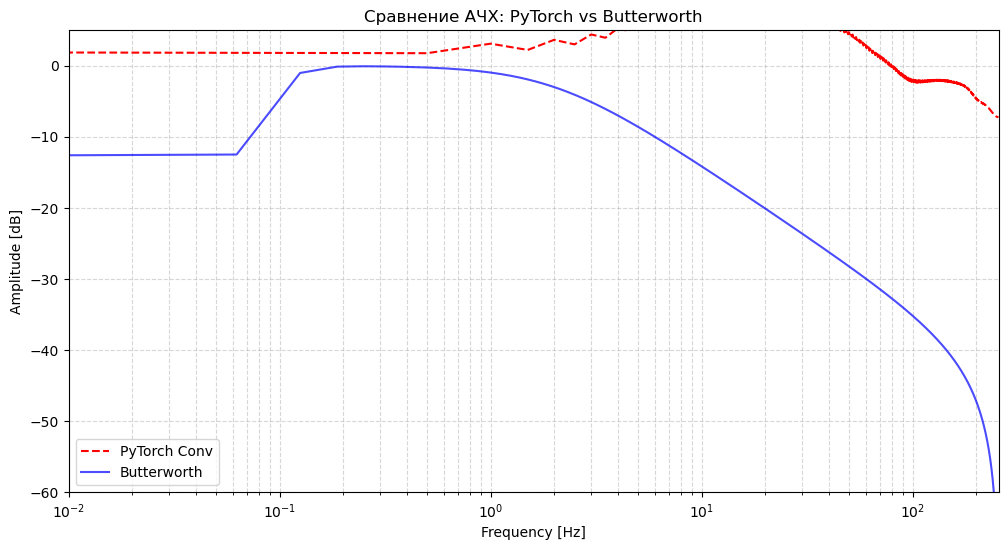

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz
import torch
import torch.nn as nn

# Параметры
Fs = 512
kernel_size = 101

# Создание фильтров Баттерворта
def butter_filter(order, cutoff, btype, fs):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a

b_vel, a_vel = butter_filter(1, 2, 'low', Fs)    # НЧ-фильтр
b_hp, a_hp = butter_filter(3, 0.1, 'high', Fs)   # ВЧ-фильтр

# class ConvBN(nn.Module):
#     def __init__(self, conv, bn):
#         super().__init__()
#         self.conv = conv
#         self.bn = bn
    
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.bn(x)
#         return x

class ConvFilter(nn.Module):
    def __init__(self, base_model, kernel_size=3, num_blocks=25, strides=[2, 2, 2]):
        super().__init__()

        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1

        # Создаем и объединяем остаточные блоки
        self.res_layers = base_model.res_layers

        self.downsample_blocks = base_model.downsample_blocks

        self.conv = base_model.conv
        self.bn = base_model.bn
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)

        for down_block in self.downsample_blocks:
            x = down_block(x)

        x = self.res_layers(x)

        x = self.conv(x)
        x = self.bn(x)

        return x

# Инициализация ядер
model_low = ConvFilter(model)

# Расчет АЧХ для сверточных слоев
def get_conv_amp(kernel, fs, n_points=4096):
    kernel_np = kernel.numpy().flatten()
    kernel_padded = np.zeros(n_points)
    kernel_padded[:len(kernel_np)] = kernel_np
    h_fft = np.fft.fft(kernel_padded)
    freq = np.fft.fftfreq(n_points, 1/fs)[:n_points//2]
    amp = np.abs(h_fft)[:n_points//2]
    return freq, amp

def generate_impulse(n_points):
    impulse = np.zeros(n_points)
    impulse[n_points//2] = 1.0  # Импульс в центре
    return torch.Tensor(impulse).view(1, 1, -1)

def get_amp_after_bn(model, fs, n_points=4096):
    # Генерируем импульс
    impulse = generate_impulse(n_points)
    # Пропускаем через модель
    with torch.no_grad():
        model.to("cpu")
        output = model(impulse).cpu().detach().numpy().flatten()
    # Вычисляем БПФ
    h_fft = np.fft.fft(output)
    freq = np.fft.fftfreq(n_points, 1/fs)[:n_points//2]
    amp = np.abs(h_fft)[:n_points//2]
    return freq, amp

def get_nn_amp(model, fs=512, n_points=8192):
    # Увеличиваем число точек для компенсации даунсэмплинга
    impulse = generate_impulse(n_points)
    
    # Пропуск через сеть
    with torch.no_grad():
        output = model(impulse).cpu().detach().numpy().flatten()
    
    # Обрезка до реальной длины после даунсэмплинга
    output = output[output != 0]  # Удаление артефактов даунсэмплинга
    
    # БПФ
    h_fft = np.fft.fft(output)
    freq = np.fft.fftfreq(len(output), 1/fs)[:len(output)//2]
    amp = np.abs(h_fft)[:len(output)//2]
    
    return freq, amp

# Получение характеристик
freq_conv_low, amp_low = get_nn_amp(model_low, Fs)
total_amp_conv = amp_low 

# АЧХ оригинальных фильтров
_, h_vel = freqz(b_vel, a_vel, worN=4096, fs=Fs)
_, h_hp = freqz(b_hp, a_hp, worN=4096, fs=Fs)
total_amp_butter = np.abs(h_vel) * np.abs(h_hp)
freq_butter = np.linspace(0, Fs/2, 4096)

# Визуализация
plt.figure(figsize=(12, 6))
plt.semilogx(freq_conv_low[:512], 20*np.log10(total_amp_conv), 
            label='PyTorch Conv', color='red', linestyle='--')
plt.semilogx(freq_butter, 20*np.log10(total_amp_butter), 
            label='Butterworth', color='blue', alpha=0.7)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.xlim(0.01, Fs/2)
plt.ylim(-60, 5)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.title('Сравнение АЧХ: PyTorch vs Butterworth')
plt.show()

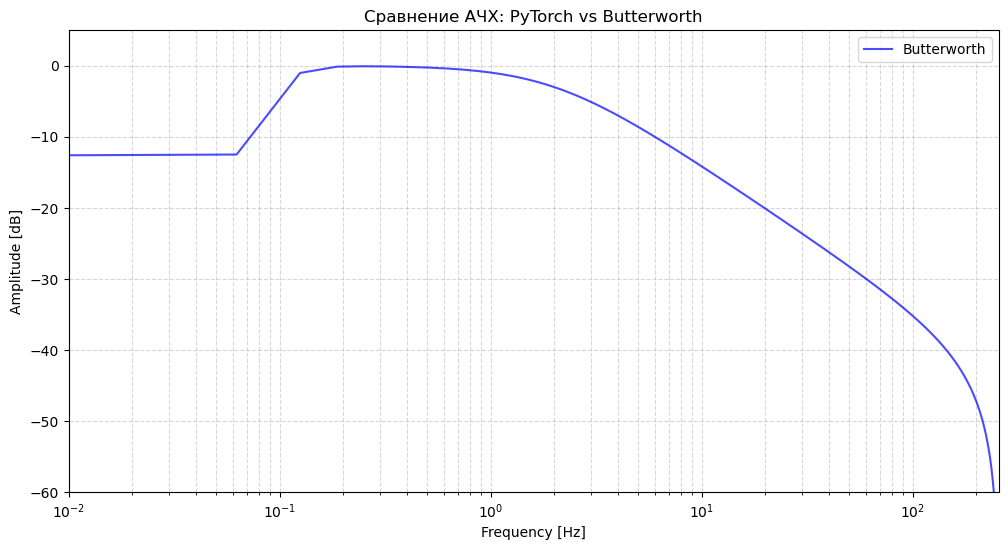

In [50]:
plt.figure(figsize=(12, 6))
# plt.semilogx(freq_conv_low[:512], 20*np.log10(total_amp_conv), 
#             label='PyTorch Conv', color='red', linestyle='--')
plt.semilogx(freq_butter, 20*np.log10(total_amp_butter), 
            label='Butterworth', color='blue', alpha=0.7)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.xlim(0.01, Fs/2)
plt.ylim(-60, 5)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.title('Сравнение АЧХ: PyTorch vs Butterworth')
plt.show()

C:\Users\laput\AppData\Local\Temp\ipykernel_26892\51102879.py:72: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(freq_conv_low, 20*np.log10(total_amp_conv),


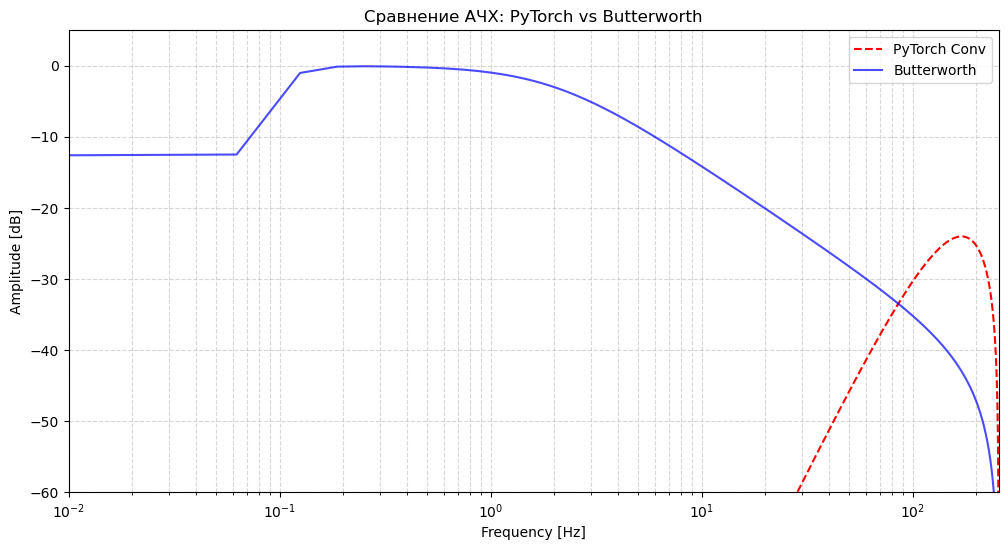

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz
import torch
import torch.nn as nn

# Параметры
Fs = 512
kernel_size = 101

# Создание фильтров Баттерворта
def butter_filter(order, cutoff, btype, fs):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a

b_vel, a_vel = butter_filter(1, 2, 'low', Fs)    # НЧ-фильтр
b_hp, a_hp = butter_filter(3, 0.1, 'high', Fs)   # ВЧ-фильтр

# Функция для создания ядра свертки
def create_kernel(b_coeffs, kernel_size):
    kernel = np.zeros(kernel_size)
    start = (kernel_size - len(b_coeffs)) // 2
    kernel[start:start+len(b_coeffs)] = b_coeffs
    return torch.Tensor(kernel).view(1, 1, -1)  # Формат [out_channels, in_channels, kernel_size]

# Инициализация ядер
kernel_low = create_kernel(b_vel, kernel_size)
kernel_high = create_kernel(b_hp, kernel_size)

# Расчет АЧХ для сверточных слоев
def get_conv_amp(kernel, fs, n_points=4096):
    kernel_np = kernel.numpy().flatten()
    kernel_padded = np.zeros(n_points)
    kernel_padded[:len(kernel_np)] = kernel_np
    h_fft = np.fft.fft(kernel_padded)
    freq = np.fft.fftfreq(n_points, 1/fs)[:n_points//2]
    amp = np.abs(h_fft)[:n_points//2]
    return freq, amp

# Получение характеристик
freq_conv_low, amp_conv_low = get_conv_amp(kernel_low, Fs)
freq_conv_high, amp_conv_high = get_conv_amp(kernel_high, Fs)
total_amp_conv = amp_conv_low * amp_conv_high

# АЧХ оригинальных фильтров
_, h_vel = freqz(b_vel, a_vel, worN=4096, fs=Fs)
_, h_hp = freqz(b_hp, a_hp, worN=4096, fs=Fs)
total_amp_butter = np.abs(h_vel) * np.abs(h_hp)
freq_butter = np.linspace(0, Fs/2, 4096)

# Визуализация
plt.figure(figsize=(12, 6))
plt.semilogx(freq_conv_low, 20*np.log10(total_amp_conv), 
            label='PyTorch Conv', color='red', linestyle='--')
plt.semilogx(freq_butter, 20*np.log10(total_amp_butter), 
            label='Butterworth', color='blue', alpha=0.7)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.xlim(0.01, Fs/2)
plt.ylim(-60, 5)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.title('Сравнение АЧХ: PyTorch vs Butterworth')
plt.show()

In [10]:
kernel_low.shape

torch.Size([1, 1, 101])

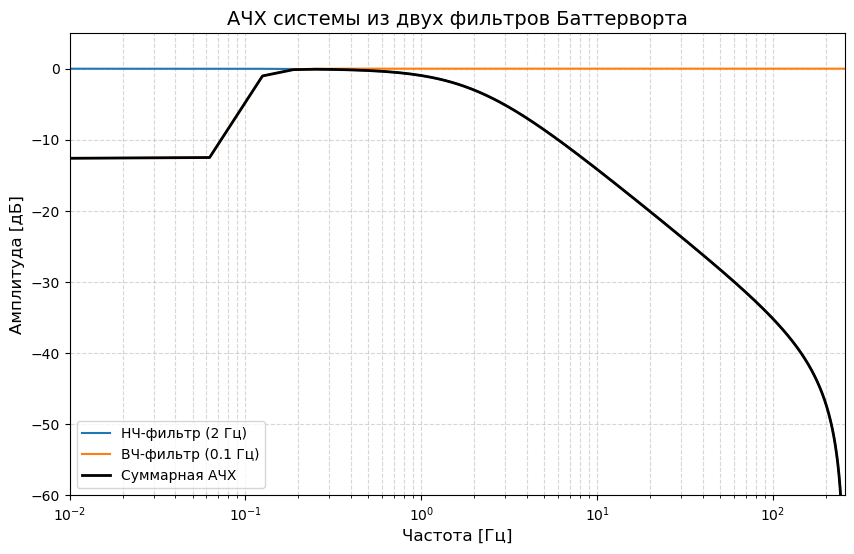

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz

# Параметры
Fs = 512  # Частота дискретизации

# Создание фильтров
def butter_filter(order, cutoff, btype, fs):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a

# Коэффициенты фильтров
b_vel, a_vel = butter_filter(order=1, cutoff=2, btype='low', fs=Fs)
b_hp, a_hp = butter_filter(order=3, cutoff=0.1, btype='high', fs=Fs)

# Расчет АЧХ
n_points = 4096  # Количество точек для расчета
freqs = np.linspace(0, Fs/2, n_points)  # Ось частот от 0 до Fs/2

# АЧХ низкочастотного фильтра (2 Гц)
w_vel, h_vel = freqz(b_vel, a_vel, worN=n_points, fs=Fs)
amp_vel = np.abs(h_vel)  # Модуль АЧХ

# АЧХ высокочастотного фильтра (0.1 Гц)
w_hp, h_hp = freqz(b_hp, a_hp, worN=n_points, fs=Fs)
amp_hp = np.abs(h_hp)  # Модуль АЧХ

# Общая АЧХ системы (произведение АЧХ)
total_amp = amp_vel * amp_hp

# Построение графиков
plt.figure(figsize=(10, 6))
plt.semilogx(w_vel, 20 * np.log10(amp_vel), label='НЧ-фильтр (2 Гц)')
plt.semilogx(w_hp, 20 * np.log10(amp_hp), label='ВЧ-фильтр (0.1 Гц)')
plt.semilogx(w_vel, 20 * np.log10(total_amp), label='Суммарная АЧХ', color='black', linewidth=2)
plt.xlabel('Частота [Гц]', fontsize=12)
plt.ylabel('Амплитуда [дБ]', fontsize=12)
plt.xlim(0.01, Fs/2)  # Ограничение по частоте
plt.ylim(-60, 5)       # Ограничение по амплитуде
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.title('АЧХ системы из двух фильтров Баттерворта', fontsize=14)
plt.show()

C:\Users\laput\AppData\Local\Temp\ipykernel_8660\1698451061.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_hp * Fs / (2 * np.pi), 20 * np.log10(abs(h_hp)), 'r')


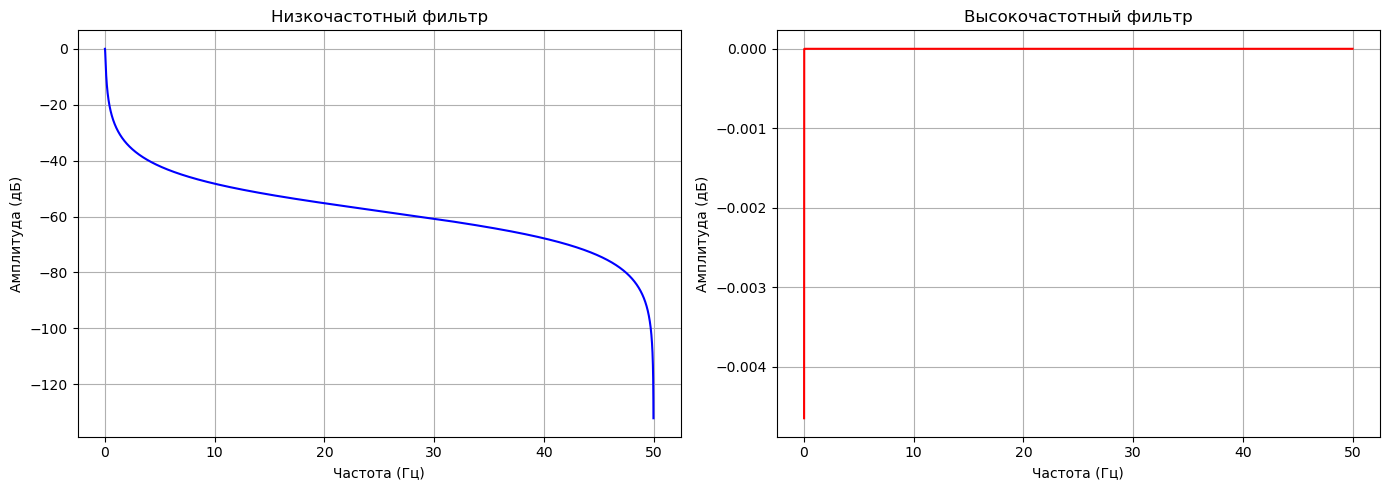

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz

# Частота дискретизации
Fs = 100.0  # Гц

# Низкочастотный фильтр
b_vel, a_vel = butter(N=1, Wn=2/(0.5*Fs), btype='low', fs=Fs)

# Высокочастотный фильтр
b_hp, a_hp = butter(N=3, Wn=0.1/(0.5*Fs), btype='high', fs=Fs)

# Частотная характеристика для низкочастотного фильтра
w_vel, h_vel = freqz(b_vel, a_vel, worN=8000)

# Частотная характеристика для высокочастотного фильтра
w_hp, h_hp = freqz(b_hp, a_hp, worN=8000)

# Визуализация
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(w_vel * Fs / (2 * np.pi), 20 * np.log10(abs(h_vel)), 'b')
plt.title('Низкочастотный фильтр')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда (дБ)')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(w_hp * Fs / (2 * np.pi), 20 * np.log10(abs(h_hp)), 'r')
plt.title('Высокочастотный фильтр')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда (дБ)')
plt.grid()

plt.tight_layout()
plt.show()


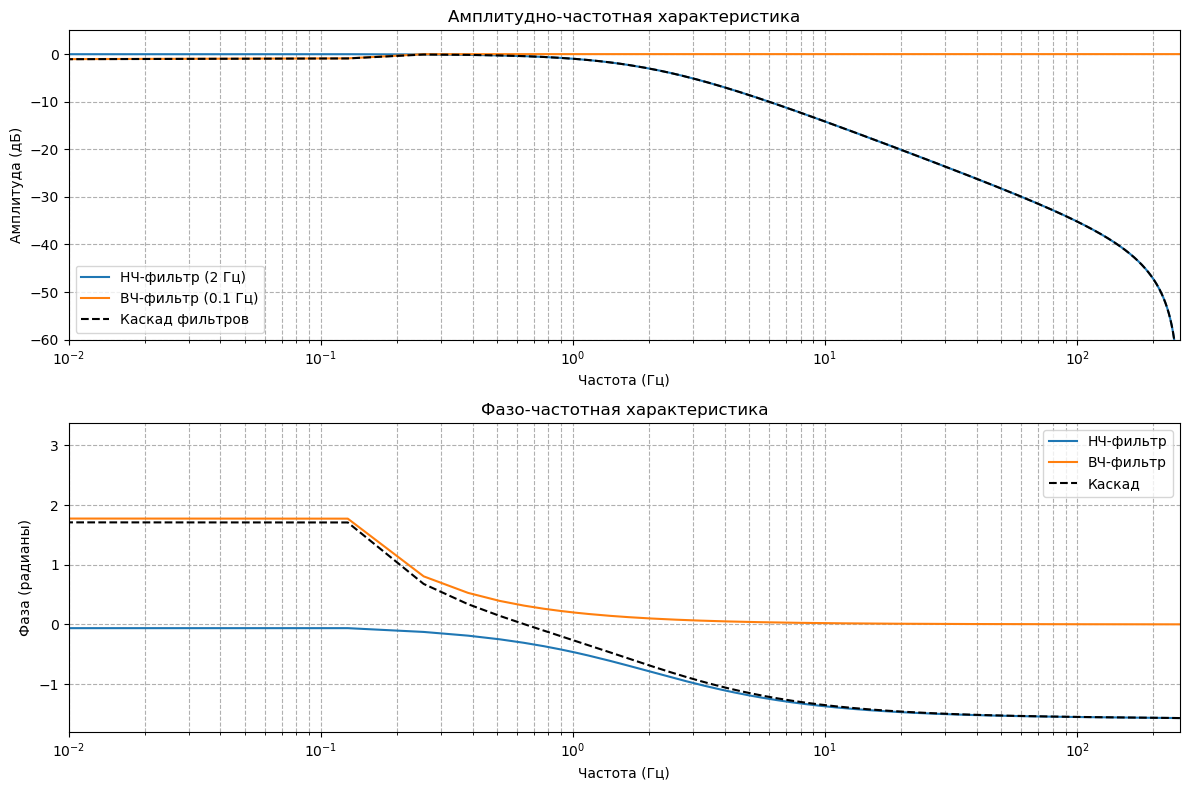

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz

# Параметры
Fs = 512  # Частота дискретизации

# Создаем фильтры
def butter_filter(order, cutoff, btype, fs):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a

# Коэффициенты фильтров
b_vel, a_vel = butter_filter(order=1, cutoff=2, btype='low', fs=Fs)
b_hp, a_hp = butter_filter(order=3, cutoff=0.1, btype='high', fs=Fs)

# 1. Частотные характеристики каждого фильтра
w_vel, h_vel = freqz(b_vel, a_vel, worN=2000)  # НЧ-фильтр
w_hp, h_hp = freqz(b_hp, a_hp, worN=2000)     # ВЧ-фильтр

# 2. Общая характеристика (каскад фильтров)
w_total = w_vel  # Используем те же частоты
h_total = h_vel * h_hp  # Перемножение комплексных характеристик

# Преобразование частот в герцы
freqs_vel = (w_vel / np.pi) * (Fs/2)
freqs_hp = (w_hp / np.pi) * (Fs/2)
freqs_total = (w_total / np.pi) * (Fs/2)

# Визуализация
plt.figure(figsize=(12, 8))

# Амплитудно-частотная характеристика (АЧХ)
plt.subplot(2, 1, 1)
plt.semilogx(freqs_vel, 20 * np.log10(np.abs(h_vel)), label='НЧ-фильтр (2 Гц)')
plt.semilogx(freqs_hp, 20 * np.log10(np.abs(h_hp)), label='ВЧ-фильтр (0.1 Гц)')
plt.semilogx(freqs_total, 20 * np.log10(np.abs(h_total)), 'k--', label='Каскад фильтров')
plt.title('Амплитудно-частотная характеристика')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда (дБ)')
plt.xlim(0.01, Fs/2)
plt.ylim(-60, 5)
plt.grid(True, which='both', linestyle='--')
plt.legend()

# Фазо-частотная характеристика (ФЧХ)
plt.subplot(2, 1, 2)
plt.semilogx(freqs_vel, np.unwrap(np.angle(h_vel)), label='НЧ-фильтр')
plt.semilogx(freqs_hp, np.unwrap(np.angle(h_hp)), label='ВЧ-фильтр')
plt.semilogx(freqs_total, np.unwrap(np.angle(h_total)), 'k--', label='Каскад')
plt.title('Фазо-частотная характеристика')
plt.xlabel('Частота (Гц)')
plt.ylabel('Фаза (радианы)')
plt.xlim(0.01, Fs/2)
plt.grid(True, which='both', linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

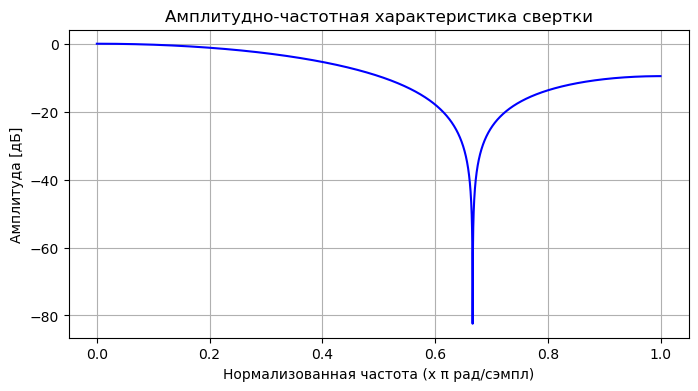

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Ядро свертки как фильтр низких частот
kernel = np.array([1, 1, 1]) / 3  # Усредняющий фильтр

# Передаточная функция
w, h = freqz(kernel, worN=8000)

# Визуализация
plt.figure(figsize=(8, 4))
plt.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
plt.title('Амплитудно-частотная характеристика свертки')
plt.xlabel('Нормализованная частота (x π рад/сэмпл)')
plt.ylabel('Амплитуда [дБ]')
plt.grid()
plt.show()


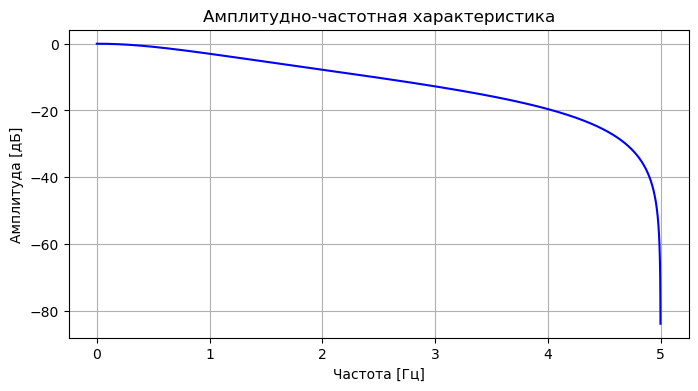

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Параметры фильтра
cutoff_frequency = 1.0  # частота среза в Гц
sample_rate = 10.0      # частота дискретизации в Гц

# Создание низкочастотного фильтра первого порядка
b, a = signal.butter(1, cutoff_frequency / (0.5 * sample_rate), btype='low')

# Частотная характеристика
w, h = signal.freqz(b, a, worN=8000)

# Плоскость для передачи частот в Гц
frequencies = w * (sample_rate / (2 * np.pi))

# Визуализация амплитудно-частотной характеристики
plt.figure(figsize=(8, 4))
plt.plot(frequencies, 20 * np.log10(abs(h)), 'b')
plt.title('Амплитудно-частотная характеристика')
plt.xlabel('Частота [Гц]')
plt.ylabel('Амплитуда [дБ]')
plt.grid()
plt.show()


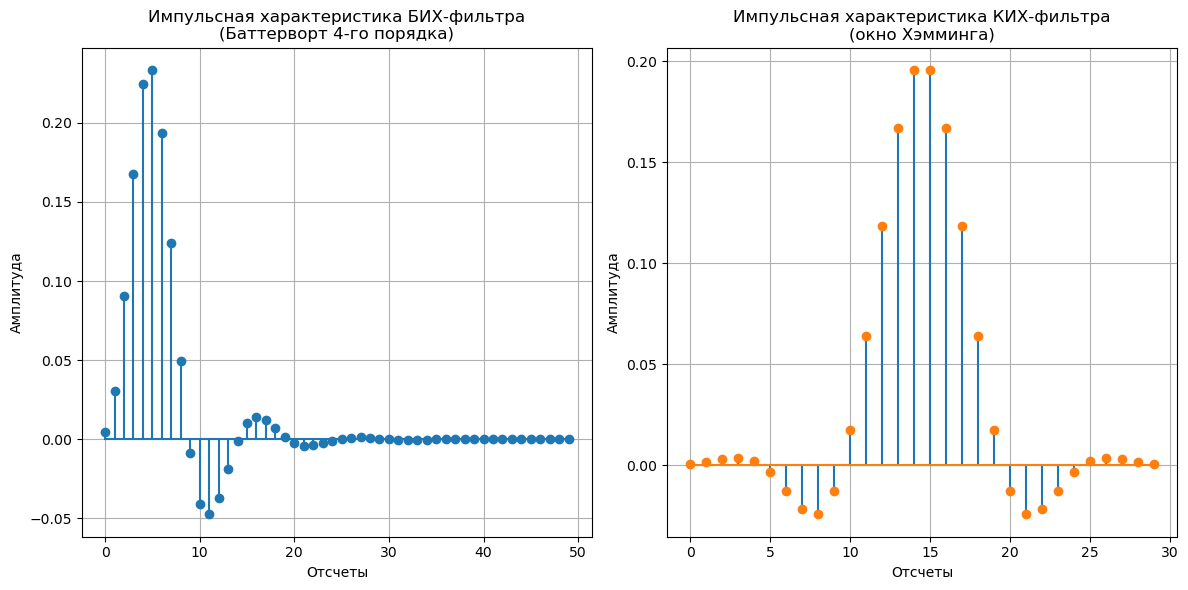

In [8]:
# Параметры сигнала
n = 50  # Количество отсчетов

# Создание единичного импульса
impulse = np.zeros(n)
impulse[0] = 1

# 1. Пример для БИХ-фильтра (Баттерворт)
order = 4          # Порядок фильтра
cutoff = 0.2       # Нормированная частота среза (от 0 до 1)

# Создание коэффициентов фильтра
b, a = signal.butter(order, cutoff)

# Применение фильтра к импульсу
response_iir = signal.lfilter(b, a, impulse)

# 2. Пример для КИХ-фильтра (фильтр с окном)
numtaps = 30       # Количество коэффициентов
taps = signal.firwin(numtaps, cutoff, window='hamming')

# Построение графиков
plt.figure(figsize=(12, 6))

# График для БИХ-фильтра
plt.subplot(1, 2, 1)
plt.stem(np.arange(n), response_iir, markerfmt='C0o', basefmt='C0-')
plt.title('Импульсная характеристика БИХ-фильтра\n(Баттерворт 4-го порядка)')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')
plt.grid(True)

# График для КИХ-фильтра
plt.subplot(1, 2, 2)
plt.stem(taps, markerfmt='C1o', basefmt='C1-')
plt.title('Импульсная характеристика КИХ-фильтра\n(окно Хэмминга)')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
50 // 2

25

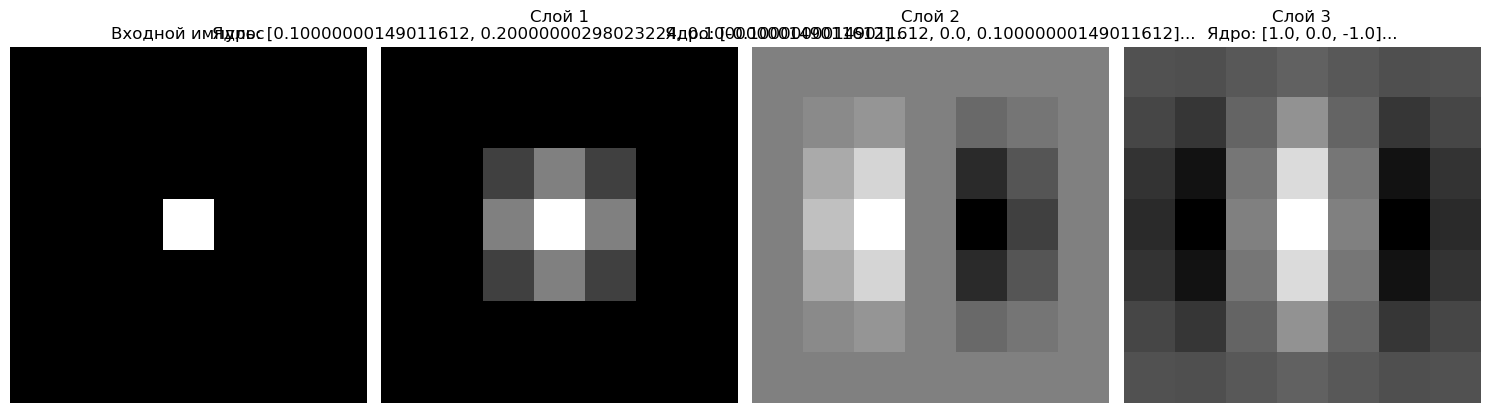

In [ ]:
# 1. Создаем модель с 3 сверточными слоями
model = nn.Sequential(
    nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False),  # Слой 1
    nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False),  # Слой 2
    nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)  # Слой 3
)

# 2. Фиксируем ядра для наглядности (можно менять!)
kernels = [
    torch.tensor([[  # Ядро 1-го слоя
        [0.1, 0.2, 0.1],
        [0.2, 0.4, 0.2],
        [0.1, 0.2, 0.1]
    ]]),
    torch.tensor([[  # Ядро 2-го слоя
        [-0.1, 0.0, 0.1],
        [-0.2, 0.0, 0.2],
        [-0.1, 0.0, 0.1]
    ]]),
    torch.tensor([[  # Ядро 3-го слоя
        [1.0, 0.0, -1.0],
        [1.0, 0.0, -1.0],
        [1.0, 0.0, -1.0]
    ]])
]

# Загружаем ядра в модель
for i, layer in enumerate(model):
    layer.weight.data = kernels[i].unsqueeze(0).float()

# 3. Создаем единичный импульс (1 канал, 7x7)
impulse = torch.zeros(1, 1, 7, 7)
impulse[0, 0, 3, 3] = 1.0  # Центральный пиксель

# 4. Собираем выходы каждого слоя
outputs = []
hooks = []

# Регистрируем хуки для захвата промежуточных результатов
def hook_fn(module, input, output):
    outputs.append(output.detach())

for layer in model:
    hooks.append(layer.register_forward_hook(hook_fn))

# 5. Пропускаем импульс через сеть
with torch.no_grad():
    final_output = model(impulse)

# Удаляем хуки
for hook in hooks:
    hook.remove()

# 6. Визуализация
plt.figure(figsize=(15, 4))

# Исходный импульс
plt.subplot(1, 4, 1)
plt.imshow(impulse[0, 0], cmap='gray', vmin=0, vmax=1)
plt.title("Входной импульс")
plt.axis('off')

# Выходы каждого слоя
for i, out in enumerate(outputs):
    plt.subplot(1, 4, i+2)
    plt.imshow(out[0, 0], cmap='gray')
    plt.title(f"Слой {i+1}\nЯдро: {kernels[i].flatten().tolist()[:3]}...")
    plt.axis('off')

plt.tight_layout()
plt.show()